# XGBoost

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

## Read dataset

In [2]:
data_train = pd.read_csv('processed_training.csv')
data_test = pd.read_csv('processed_test.csv')
data_train.head()

,attendance,is_federal_holiday,venue,on_grass,temperature,wind_speed,team1_name,team1_pre_win,team1_pre_loss,team1_pre_win_pct,...,weather_Rain,weather_Sunny,season_type,season,home_team_avg_att_last_year,start_hour,start_hour_label_afternoon,start_hour_label_evening,start_hour_label_night,start_hour_label_noon
0,35055,0,Wrigley Field,1,-2.786672,-0.093090,STL,-1.62645,-1.654514,0.0,...,0,1,regular,2015,0.345307,19,0,1,0,0
1,49043,0,Chase Field,1,0.705205,-0.093090,SFG,-1.62645,-1.654514,0.0,...,0,1,regular,2015,-0.573314,19,0,1,0,0
2,43633,0,Great American Ball Park,1,-0.521670,1.490839,PIT,-1.62645,-1.654514,0.0,...,0,0,regular,2015,0.066649,16,1,0,0,0
3,45030,0,Comerica Park,1,-2.031671,-0.489072,MIN,-1.62645,-1.654514,0.0,...,0,0,regular,2015,0.766348,13,0,0,0,1
4,43753,0,Minute Maid Park,1,0.516455,1.292848,CLE,-1.62645,-1.654514,0.0,...,0,0,regular,2015,-1.084575,18,0,1,0,0


In [3]:
data_train.drop(['venue', 'start_hour'], axis=1, inplace=True)
data_test.drop(['venue', 'start_hour'], axis=1, inplace=True)

In [4]:
data_train = pd.get_dummies(data_train, columns=['team1_name'])
data_test = pd.get_dummies(data_test, columns=['team1_name'])

In [5]:
data_train = pd.get_dummies(data_train, columns=['team2_name'])
data_test = pd.get_dummies(data_test, columns=['team2_name'])

In [6]:
data_train = pd.get_dummies(data_train, columns=['season_type'])
data_test = pd.get_dummies(data_test, columns=['season_type'])

In [7]:
train_cols = data_train.columns.tolist()
data_test = data_test[train_cols].copy()

In [8]:
print(set(data_train.columns) - set(data_test.columns))
print(set(data_test.columns) - set(data_train.columns))

set()
set()


In [9]:
from sklearn.utils import shuffle
data_train = shuffle(data_train)

In [10]:
y_train = data_train['attendance'].to_numpy()
y_test = data_test['attendance'].to_numpy()

data_train.drop(['attendance'], axis=1, inplace=True)
data_test.drop(['attendance'], axis=1, inplace=True)

x_train = data_train.to_numpy()
x_test = data_test.to_numpy()

print(x_train.shape)

(12270, 273)


## kfold

In [11]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
kf.get_n_splits(x_train)

5

In [12]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [13]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
parameters = {'n_estimators': [100, 300, 500, 1000], 'max_depth':[3, 5, 8, 10], 'learning_rate': [0.1, 0.05, 0.01, 0.001], 'colsample_bytree': [0.3, 0.7, 1]}
model = XGBRegressor(random_state=42)
clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring=scoring, refit='neg_root_mean_squared_error')
clf.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.7, 1],
                         'learning_rate': [0.1, 0.05, 0.01, 0.001],
                         'max_depth': [3, 5, 8, 10],
                         'n_estimators': [100, 300, 500, 1000]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

In [16]:
print("Best estimators:", clf.best_estimator_)
print("Best parameters:", clf.best_params_)

Best estimators: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=8, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)
Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000}


In [17]:
df_res = pd.DataFrame(data=clf.cv_results_)
df_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_neg_mean_squared_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,2.995321,0.030717,0.039835,0.000750,0.3,0.1,3,100,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-2.594823e+07,...,31.945466,118,-0.162909,-0.171270,-0.163074,-0.156932,-0.161269,-0.163091,0.004652,118
1,8.593403,0.232977,0.048244,0.001471,0.3,0.1,3,300,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-2.159451e+07,...,34.082385,96,-0.143330,-0.150442,-0.139939,-0.138256,-0.140630,-0.142519,0.004285,98
2,14.348027,0.425265,0.056653,0.001962,0.3,0.1,3,500,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-2.014178e+07,...,32.623213,86,-0.137309,-0.143659,-0.133450,-0.132431,-0.134507,-0.136271,0.004037,84
3,27.592251,0.448472,0.083475,0.005857,0.3,0.1,3,1000,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-1.876574e+07,...,40.535823,70,-0.130844,-0.135564,-0.125880,-0.126039,-0.128659,-0.129397,0.003586,68
4,4.193808,0.048735,0.044841,0.000981,0.3,0.1,5,100,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-2.137225e+07,...,15.531931,94,-0.143541,-0.149107,-0.143233,-0.138894,-0.141714,-0.143298,0.003338,99


## Train with best params

In [18]:
xgb = XGBRegressor(colsample_bytree=0.3, learning_rate=0.05, max_depth=8, n_estimators=1000, random_state=42)
xgb = xgb.fit(x_train, y_train)

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
train_predict = xgb.predict(x_train)
print("Train MSE:", mean_squared_error(y_train, train_predict))
print("Train RMSE:", mean_squared_error(y_train, train_predict, squared=False))
print("Train MAE:", mean_absolute_error(y_train, train_predict))
print("Train MAPE:", mean_absolute_percentage_error(y_train, train_predict))

Train MSE: 1250365.3409494993
Train RMSE: 1118.1973622529697
Train MAE: 821.3301695334785
Train MAPE: 0.03271076603698466


Text(0.5, 0, 'Xgboost Feature Importance')

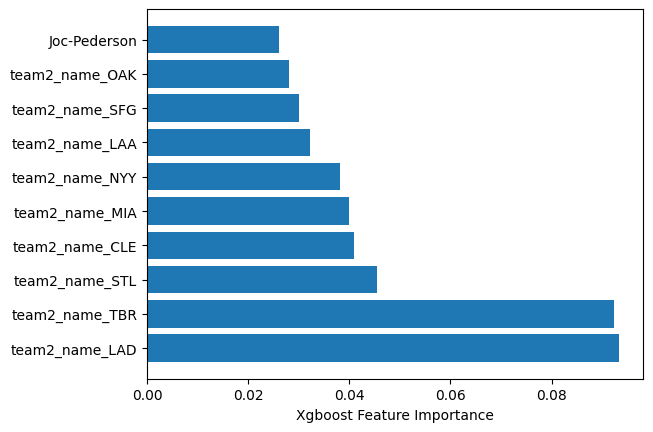

In [20]:
from matplotlib import pyplot as plt
sorted_idx = xgb.feature_importances_.argsort()[::-1]
cols = data_train.columns
plt.barh(cols[sorted_idx][:10], xgb.feature_importances_[sorted_idx][:10])
plt.xlabel("Xgboost Feature Importance")

In [21]:
xgb.feature_importances_[sorted_idx][:10]

array([0.09342138, 0.09239689, 0.0453709 , 0.04093456, 0.04000404,
       0.03817052, 0.03220022, 0.03012056, 0.02813813, 0.026102  ],
      dtype=float32)

## Testing set

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
y_pred = xgb.predict(x_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, y_pred))

Test MSE: 34925219.93062326
Test RMSE: 5909.756334285134
Test MAE: 4648.007279884011
Test MAPE: 0.23873932041453147


## Save model

In [23]:
import pickle
from datetime import datetime
time = datetime.today().strftime('%Y%m%d_%H%M%S')
filename = f'./model/xgboost_model_{time}.sav'
pickle.dump(xgb, open(filename, 'wb'))
cv_filename = f'./model/xgboost_model_{time}_cv.csv'
df_res.to_csv(cv_filename, index=False)
# loaded_model = pickle.load(open(filename, 'rb'))